In [1]:
import os 
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import catboost
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')
import seaborn as sn
from scipy.stats import pearsonr
import imblearn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [2]:
home_loans = pd.read_excel('DigiHack Dataset.xlsx', sheet_name='Data')
print("No. of rows in dataset:",len(home_loans))
print("No. of unique IDs:",len(home_loans.iloc[:,0].unique()))

No. of rows in dataset: 3980
No. of unique IDs: 3894


In [3]:
home_loans.drop_duplicates(inplace = True)
home_loans.shape

(3894, 35)

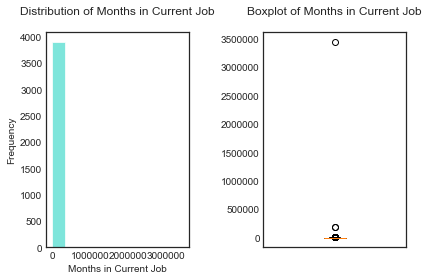

In [4]:
fig, ax = plt.subplots(1,2)
ax[0].hist(home_loans.Months_in_current_job, edgecolor="white", color = '#47DBCD', alpha = 0.7)
ax[0].set_title("Distribution of Months in Current Job\n")
ax[0].set_xlabel("Months in Current Job")
ax[0].set_ylabel("Frequency")
ax[1].boxplot(home_loans.Months_in_current_job)
ax[1].set_title("Boxplot of Months in Current Job\n")
ax[1].set_xticks([])
fig.tight_layout();

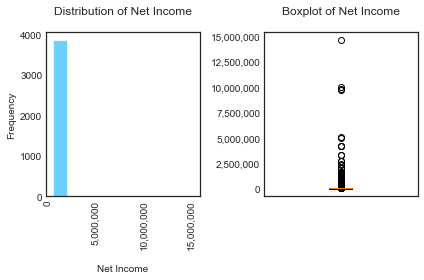

In [5]:
fig, ax = plt.subplots(1,2)
ax[0].hist(home_loans.Net_income, edgecolor="white", color = '#2CBDFE', alpha = 0.7, bins = 10)
ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0].set_title("Distribution of Net Income\n")
ax[0].set_xlabel("\nNet Income")
ax[0].set_ylabel("Frequency")
plt.setp(ax[0].get_xticklabels(), rotation=90, horizontalalignment='right')
ax[1].boxplot(home_loans.Net_income)
ax[1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1].set_title("Boxplot of Net Income\n")
ax[1].set_xticks([])
fig.tight_layout();

Hence we remove the datapoints having Months_in_current_job >= 180000

Pearsons correlation: 0.932


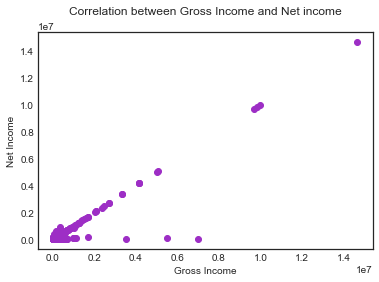

In [6]:
corr, _ = pearsonr(home_loans.Gross_income, home_loans.Net_income)
print('Pearsons correlation: %.3f' % corr)
plt.scatter(home_loans.Gross_income, home_loans.Net_income, color = '#9D2EC5')
plt.title("Correlation between Gross Income and Net income\n")
plt.xlabel('Gross Income')  
plt.ylabel('Net Income');

Either Gross_income or Net_income should be removed to avoid multicollinearity

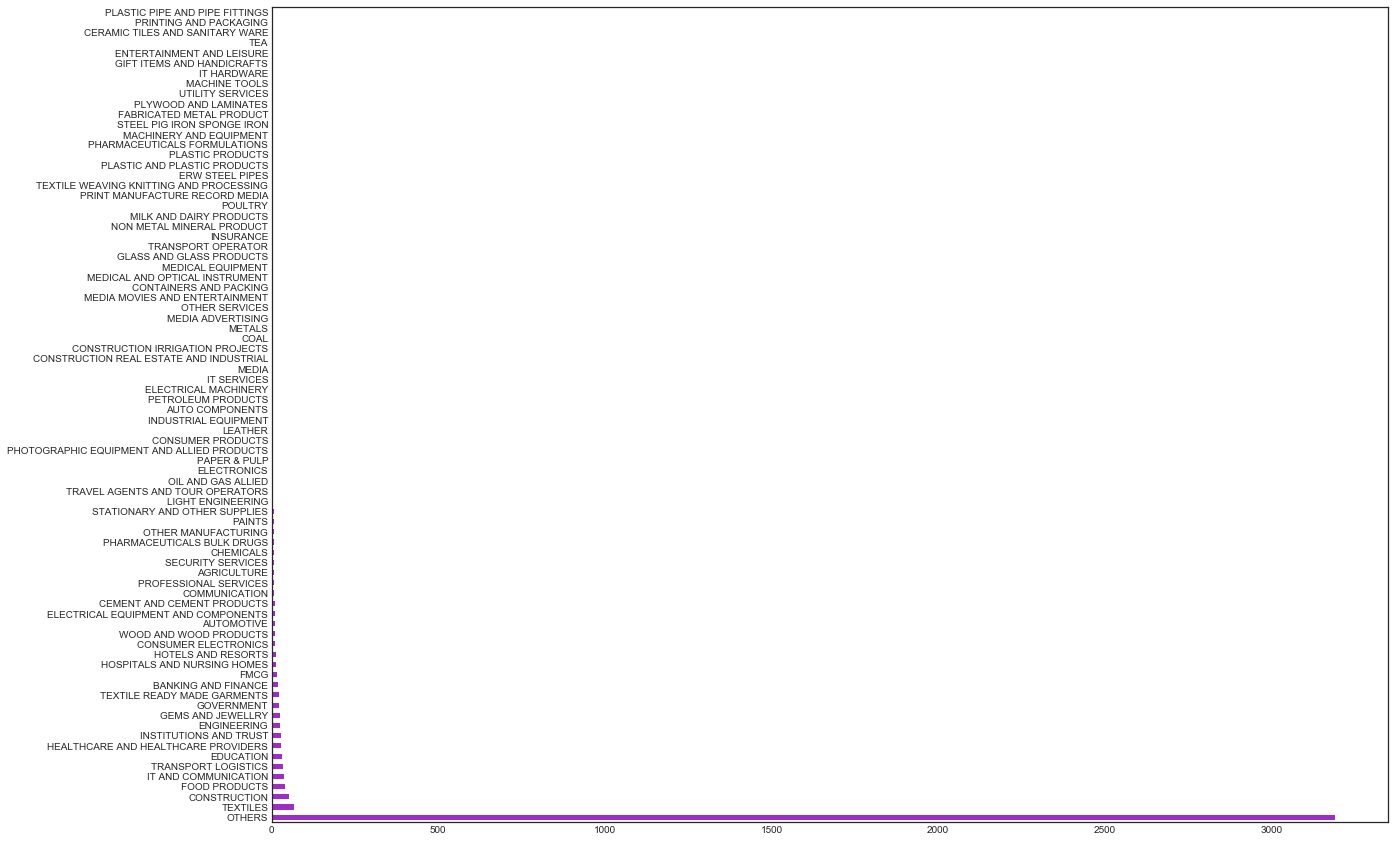

In [8]:
home_loans['Type_of_industry'].value_counts().plot(kind = 'barh', color = '#9D2EC5')
plt.rcParams["figure.figsize"] = (40, 30);

More than 3500 datapoints in feature Type_of_industry are of category OTHERS and there are multiple other categories having just one or two observations each, so it is not sensible including the feature in our analysis

In [9]:
#Removing outliers and redundant variables
home_loans.drop(home_loans.loc[home_loans['Months_in_current_job']>=180000].index, inplace=True)
home_loans.drop(home_loans.loc[home_loans['Bank_balance']<0].index, inplace=True)
home_loans.drop(['Gross_income', 'ID','Type_of_industry'], axis=1, inplace=True)
home_loans.drop(home_loans.loc[home_loans['Net_income']<0].index, inplace=True)
#Treating highly positively skewed net income variable
home_loans['Net_income'].replace(0, 0.08, inplace=True)
home_loans['Net_income_log'] = np.log(home_loans['Net_income'])
home_loans.shape

(3887, 33)

In [10]:
home_loans.SEX.fillna("Other", inplace = True)
home_loans.Marital_Status.fillna("Other", inplace = True)

In [11]:
Dummy_Variables=[pd.get_dummies(home_loans['SEX'],prefix = 'SEX', prefix_sep = '_'),
                 pd.get_dummies(home_loans['Org_Type'],prefix = 'Org_Type', prefix_sep = '_'),
                 pd.get_dummies(home_loans['Marital_Status'],prefix = 'Marital_Status', prefix_sep = '_'),
                 pd.get_dummies(home_loans['Customer_type'],prefix = 'Customer_type', prefix_sep = '_')]
Dummy_Variables=pd.concat(Dummy_Variables,axis=1)
home_loans=pd.concat([home_loans,Dummy_Variables],axis=1)
home_loans.drop(columns = ['Customer_type' , 'SEX','Marital_Status','SEX_Other','Org_Type_MNC',
                           'Marital_Status_Other','Customer_type_NON EARNING'], axis = 1, inplace = True)
home_loans.shape

(3887, 49)

Using Weight of Evidence to Bin Variables: 

/Users/poojaaryamane/opt/anaconda3/lib/python3.7/site-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


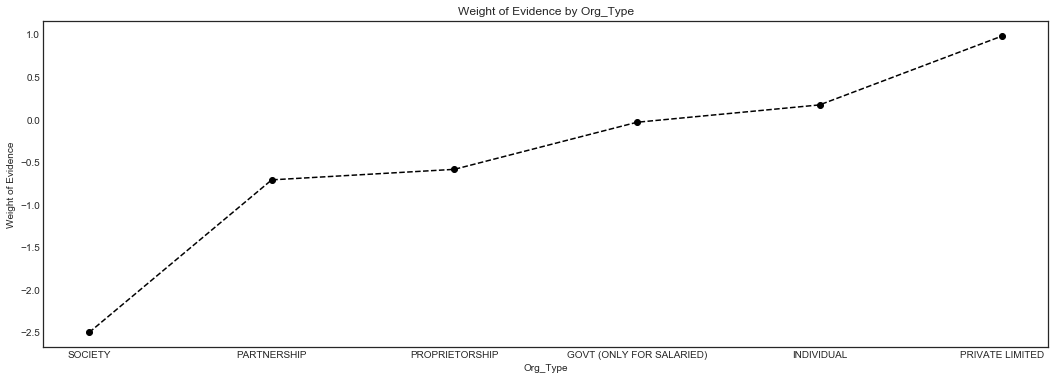

In [12]:
X = home_loans.loc[:, home_loans.columns != 'Target']
y_woe = 1 - home_loans['Target']

def woe_discrete(df, discrete_variable_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variable_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

df_org_type = woe_discrete(X,"Org_Type",y_woe)

def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[: , 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize = (18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

plot_by_woe(df_org_type)

In [13]:
home_loans['Org_Type_Part_Prop'] = sum([home_loans['Org_Type_PARTNERSHIP'],home_loans['Org_Type_PROPRIETORSHIP']])
home_loans['Org_Type_Govt_Indiv'] = sum([home_loans['Org_Type_GOVT (ONLY FOR SALARIED)'],home_loans['Org_Type_INDIVIDUAL']])

home_loans.drop(columns = ['Org_Type_PARTNERSHIP' , 'Org_Type_PROPRIETORSHIP','Org_Type_GOVT (ONLY FOR SALARIED)',
                           'Org_Type_INDIVIDUAL' ], axis = 1, inplace = True)

Organisation type: Partnership + Proprietorship and Govt + Individual can be combined
based on similar behaviour 

In [14]:
#Binning continuos variable - net income 
home_loans['net_inc_slabs'] = pd.cut(home_loans['Net_income_log'], 7)
home_loans['net_inc_slabs']

def woe_ordered_continuous(df, discrete_variable_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variable_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [15]:
#Overwrite X and y_woe for updated data 
X = home_loans.loc[:, home_loans.columns != 'Target']
y_woe = 1 - home_loans['Target']
df_net_income = woe_ordered_continuous(X,'net_inc_slabs',y_woe)
df_net_income

,net_inc_slabs,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-2.545, 0.192]",231,0.874459,0.059429,202.0,29.0,0.056252,0.097973,-0.554855,NaN,NaN,0.125631
1,"(0.192, 2.91]",70,0.871429,0.018009,61.0,9.0,0.016987,0.030405,-0.582177,0.003030,0.027323,0.125631
2,"(2.91, 5.628]",6,0.833333,0.001544,5.0,1.0,0.001392,0.003378,-0.886389,0.038095,0.304211,0.125631
3,"(5.628, 8.347]",19,0.947368,0.004888,18.0,1.0,0.005013,0.003378,0.394545,0.114035,1.280934,0.125631
4,"(8.347, 11.065]",2810,0.939502,0.722923,2640.0,170.0,0.735171,0.574324,0.246909,0.007867,0.147636,0.125631
5,"(11.065, 13.783]",720,0.888889,0.185233,640.0,80.0,0.178223,0.270270,-0.416385,0.050613,0.663294,0.125631
6,"(13.783, 16.501]",31,0.806452,0.007975,25.0,6.0,0.006962,0.020270,-1.068710,0.082437,0.652325,0.125631


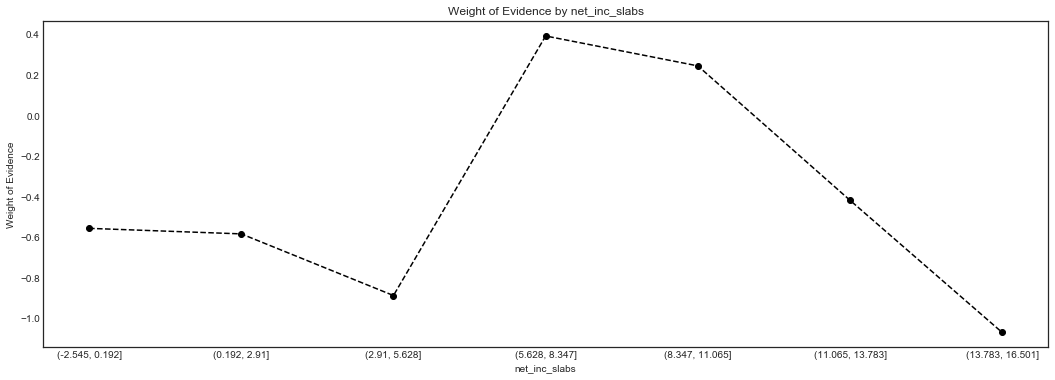

In [16]:
plot_by_woe(df_net_income)

Based on the plot, we can see that ln(net_income) from the range -2.545 to 2.91 can be clubbed together while binning. 

In [17]:
from numpy import arange
home_loans['Net_income_low'] = np.where(home_loans['Net_income_log'].isin(arange(-2.545, 2.91,0.001)), 1, 0)
home_loans['Net_income_low_medium'] = np.where(home_loans['Net_income_log'].isin(arange(2.91, 5.628,0.001)), 1, 0)
home_loans['Net_income_medium'] = np.where(home_loans['Net_income_log'].isin(arange(5.628, 8.347,0.001)), 1, 0)
home_loans['Net_income_medium_high'] = np.where(home_loans['Net_income_log'].isin(arange(8.347, 11.065,0.001)), 1, 0)
home_loans['Net_income_high'] = np.where(home_loans['Net_income_log'].isin(arange(11.065, 13.783,0.001)), 1, 0)
home_loans['Net_income_very_high'] = np.where(home_loans['Net_income_log'].isin(arange(13.783, 16.501,0.001)), 1, 0)
home_loans.columns

Index(['Age', 'Net_income', 'Months_in_city', 'Months_in_current_job',
       'Org_Type', 'Bank_balance', 'Debt_ratio', 'Target', 'ENQ_1', 'ENQ_2',
       'ENQ_3', 'ENQ_4', 'ENQ_5', 'ENQ_6', 'ENQ_7', 'ENQ_8', 'ACCOUNT_9',
       'ACCOUNT_10', 'ACCOUNT_11', 'ACCOUNT_12', 'ACCOUNT_13', 'ACCOUNT_14',
       'ACCOUNT_15', 'ACCOUNT_16', 'ACCOUNT_17', 'ACCOUNT_18', 'ACCOUNT_19',
       'ACCOUNT_20', 'ACCOUNT_21', 'Net_income_log', 'SEX_FEMALE', 'SEX_MALE',
       'Org_Type_ASSOCIATION OF PEOPLE',
       'Org_Type_CLOSELY HELD - PUBLIC LIMITED',
       'Org_Type_LISTED - PUBLIC LIMITED', 'Org_Type_PRIVATE LIMITED',
       'Org_Type_SOCIETY', 'Org_Type_TRUST', 'Marital_Status_DIVORCED',
       'Marital_Status_MARRIED', 'Marital_Status_SEPARATED',
       'Marital_Status_SINGLE', 'Marital_Status_WIDOWED',
       'Customer_type_SALARIED', 'Customer_type_SELF EMPLOYED',
       'Org_Type_Part_Prop', 'Org_Type_Govt_Indiv', 'net_inc_slabs',
       'Net_income_low', 'Net_income_low_medium', 'Net_incom

In [18]:
home_loans.drop(columns = ['Net_income_log' , 'net_inc_slabs','Org_Type'], axis = 1, inplace = True)
home_loans.columns

Index(['Age', 'Net_income', 'Months_in_city', 'Months_in_current_job',
       'Bank_balance', 'Debt_ratio', 'Target', 'ENQ_1', 'ENQ_2', 'ENQ_3',
       'ENQ_4', 'ENQ_5', 'ENQ_6', 'ENQ_7', 'ENQ_8', 'ACCOUNT_9', 'ACCOUNT_10',
       'ACCOUNT_11', 'ACCOUNT_12', 'ACCOUNT_13', 'ACCOUNT_14', 'ACCOUNT_15',
       'ACCOUNT_16', 'ACCOUNT_17', 'ACCOUNT_18', 'ACCOUNT_19', 'ACCOUNT_20',
       'ACCOUNT_21', 'SEX_FEMALE', 'SEX_MALE',
       'Org_Type_ASSOCIATION OF PEOPLE',
       'Org_Type_CLOSELY HELD - PUBLIC LIMITED',
       'Org_Type_LISTED - PUBLIC LIMITED', 'Org_Type_PRIVATE LIMITED',
       'Org_Type_SOCIETY', 'Org_Type_TRUST', 'Marital_Status_DIVORCED',
       'Marital_Status_MARRIED', 'Marital_Status_SEPARATED',
       'Marital_Status_SINGLE', 'Marital_Status_WIDOWED',
       'Customer_type_SALARIED', 'Customer_type_SELF EMPLOYED',
       'Org_Type_Part_Prop', 'Org_Type_Govt_Indiv', 'Net_income_low',
       'Net_income_low_medium', 'Net_income_medium', 'Net_income_medium_high',
       'Ne

Imputing Missing Values:

In [19]:
num_cols = home_loans[["Age","Net_income", "Months_in_city", "Months_in_current_job", "Bank_balance",
                      "Debt_ratio","ENQ_1", "ENQ_2", "ENQ_3", "ENQ_4", "ENQ_5", "ENQ_6", "ENQ_7", "ENQ_8",
                      "ACCOUNT_9", "ACCOUNT_10", "ACCOUNT_11", "ACCOUNT_12", "ACCOUNT_13","ACCOUNT_14", 
                       "ACCOUNT_15", "ACCOUNT_16", "ACCOUNT_17", "ACCOUNT_18","ACCOUNT_19", 
                       "ACCOUNT_20", "ACCOUNT_21"]]
print("Shape of num_cols: ",num_cols.shape)
imputer = IterativeImputer(estimator=BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
imputer.fit(num_cols)
imputed_num_cols = pd.DataFrame(imputer.transform(num_cols))
imputed_num_cols.columns = num_cols.columns
print("Shape of imputed_num_cols: ",imputed_num_cols.shape)

Shape of num_cols:  (3887, 27)
Shape of imputed_num_cols:  (3887, 27)


In [19]:
percent_nulls_new = (len(imputed_num_cols) - imputed_num_cols.count())/len(imputed_num_cols)
print(percent_nulls_new)
print(imputed_num_cols.head())

Age                      0.0
Net_income               0.0
Months_in_city           0.0
Months_in_current_job    0.0
Bank_balance             0.0
Debt_ratio               0.0
ENQ_1                    0.0
ENQ_2                    0.0
ENQ_3                    0.0
ENQ_4                    0.0
ENQ_5                    0.0
ENQ_6                    0.0
ENQ_7                    0.0
ENQ_8                    0.0
ACCOUNT_9                0.0
ACCOUNT_10               0.0
ACCOUNT_11               0.0
ACCOUNT_12               0.0
ACCOUNT_13               0.0
ACCOUNT_14               0.0
ACCOUNT_15               0.0
ACCOUNT_16               0.0
ACCOUNT_17               0.0
ACCOUNT_18               0.0
ACCOUNT_19               0.0
ACCOUNT_20               0.0
ACCOUNT_21               0.0
dtype: float64
    Age  Net_income  Months_in_city  Months_in_current_job  Bank_balance  \
0  40.0     62491.0           229.0                  108.0       37806.0   
1  35.0     53617.0           408.0               

In [20]:
home_loans.drop(columns = ["Age","Net_income", "Months_in_city", "Months_in_current_job", "Bank_balance",
                      "Debt_ratio","ENQ_1", "ENQ_2", "ENQ_3", "ENQ_4", "ENQ_5", "ENQ_6", "ENQ_7", "ENQ_8",
                      "ACCOUNT_9", "ACCOUNT_10", "ACCOUNT_11", "ACCOUNT_12", "ACCOUNT_13","ACCOUNT_14", 
                       "ACCOUNT_15", "ACCOUNT_16", "ACCOUNT_17", "ACCOUNT_18","ACCOUNT_19", 
                       "ACCOUNT_20", "ACCOUNT_21"], axis = 1, inplace = True)
home_loans.shape

(3887, 24)

In [21]:
cols1 = list(home_loans.columns)
cols2 = list(imputed_num_cols.columns)
cols = cols1 + cols2
home_loans = pd.DataFrame(np.hstack([home_loans, imputed_num_cols]), columns = cols)
home_loans.head()
home_loans.drop(columns = ['Net_income'], axis=1, inplace = True)
home_loans.columns

Index(['Target', 'SEX_FEMALE', 'SEX_MALE', 'Org_Type_ASSOCIATION OF PEOPLE',
       'Org_Type_CLOSELY HELD - PUBLIC LIMITED',
       'Org_Type_LISTED - PUBLIC LIMITED', 'Org_Type_PRIVATE LIMITED',
       'Org_Type_SOCIETY', 'Org_Type_TRUST', 'Marital_Status_DIVORCED',
       'Marital_Status_MARRIED', 'Marital_Status_SEPARATED',
       'Marital_Status_SINGLE', 'Marital_Status_WIDOWED',
       'Customer_type_SALARIED', 'Customer_type_SELF EMPLOYED',
       'Org_Type_Part_Prop', 'Org_Type_Govt_Indiv', 'Net_income_low',
       'Net_income_low_medium', 'Net_income_medium', 'Net_income_medium_high',
       'Net_income_high', 'Net_income_very_high', 'Age', 'Months_in_city',
       'Months_in_current_job', 'Bank_balance', 'Debt_ratio', 'ENQ_1', 'ENQ_2',
       'ENQ_3', 'ENQ_4', 'ENQ_5', 'ENQ_6', 'ENQ_7', 'ENQ_8', 'ACCOUNT_9',
       'ACCOUNT_10', 'ACCOUNT_11', 'ACCOUNT_12', 'ACCOUNT_13', 'ACCOUNT_14',
       'ACCOUNT_15', 'ACCOUNT_16', 'ACCOUNT_17', 'ACCOUNT_18', 'ACCOUNT_19',
       'ACCOUNT_

# Model Fitting

0.0    0.923849
1.0    0.076151
Name: Target, dtype: float64

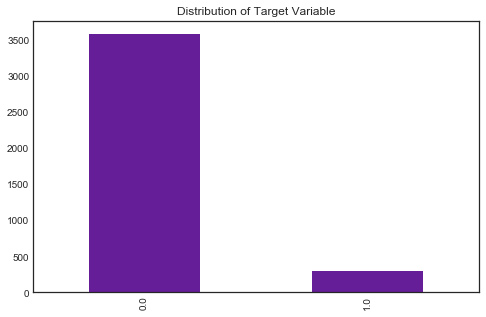

In [22]:
#Checking if the Target is Balanced
plt.rcParams["figure.figsize"] = (8, 5);
home_loans['Target'].value_counts().plot(kind='bar', color = '#661D98')
plt.title("Distribution of Target Variable")
home_loans['Target'].value_counts()/len(home_loans)
#92% of target values are '0' - so the minority class needs to be oversampled 

In [23]:
#Oversampling using SMOTE
X = home_loans.loc[:, home_loans.columns != 'Target']
y = home_loans.loc[:, home_loans.columns == 'Target']
os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X, y)
os_data_X = pd.DataFrame(data=os_data_X,columns=X.columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['Target'])

os_data_y

print("length of oversampled data is ",len(os_data_X))
print("Number of no loan in oversampled data",len(os_data_y[os_data_y['Target']==0]))
print("Number of loan",len(os_data_y[os_data_y['Target']==1]))
print("Proportion of no loan data in oversampled data is ",len(os_data_y[os_data_y['Target']==0])/len(os_data_X))
print("Proportion of loan data in oversampled data is ",len(os_data_y[os_data_y['Target']==1])/len(os_data_X))

length of oversampled data is  7182
Number of no loan in oversampled data 3591
Number of loan 3591
Proportion of no loan data in oversampled data is  0.5
Proportion of loan data in oversampled data is  0.5


In [24]:
#Splitting Data into Train and Test Sets 
from sklearn.model_selection import train_test_split
X = home_loans.loc[:, home_loans.columns != 'Target']
y = home_loans.loc[:, home_loans.columns == 'Target']
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)

(5745, 49)
(1437, 49)


## Logistic Regression

In [85]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

print(os_data_X.columns)

C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


[False False False False False False False False False False False False
 False False False False False False False False False False False  True
  True  True  True  True  True  True  True False  True  True  True  True
 False  True  True  True False False  True False False  True  True  True
  True]
[13 12 24 21 16 14 20 22 19 10 23 15 17  3  5  9  7 25 26 30 29 27 28  1
  1  1  1  1  1  1  1  4  1  1  1  1  8  1  1  1 18  6  1 11  2  1  1  1
  1]
Index(['SEX_FEMALE', 'SEX_MALE', 'Org_Type_ASSOCIATION OF PEOPLE',
       'Org_Type_CLOSELY HELD - PUBLIC LIMITED',
       'Org_Type_LISTED - PUBLIC LIMITED', 'Org_Type_PRIVATE LIMITED',
       'Org_Type_SOCIETY', 'Org_Type_TRUST', 'Marital_Status_DIVORCED',
       'Marital_Status_MARRIED', 'Marital_Status_SEPARATED',
       'Marital_Status_SINGLE', 'Marital_Status_WIDOWED',
       'Customer_type_SALARIED', 'Customer_type_SELF EMPLOYED',
       'Org_Type_Part_Prop', 'Org_Type_Govt_Indiv', 'Net_income_low',
       'Net_income_low_medium', 'Net_

In [86]:
cols=['Customer_type_SALARIED', 'Age', 'Months_in_city', 'Months_in_current_job', 'ENQ_1', 'ENQ_2', 'ENQ_3', 
      'ENQ_5', 'ENQ_6', 'ENQ_7', 'ENQ_8', 'ACCOUNT_10', 'ACCOUNT_11', 'ACCOUNT_12', 'ACCOUNT_15', 
      'ACCOUNT_18', 'ACCOUNT_19', 'ACCOUNT_20', "ACCOUNT_21"] 
X=os_data_X[X.columns]
y=os_data_y['Target']

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression(max_iter=100000,solver='newton-cg')
logreg.fit(X_train, y_train)

C:\Users\Ananya\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Ananya\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Ananya\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Ananya\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Ananya\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The 

LogisticRegression(max_iter=100000, solver='newton-cg')

In [88]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.71


In [89]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[784 290]
 [337 744]]


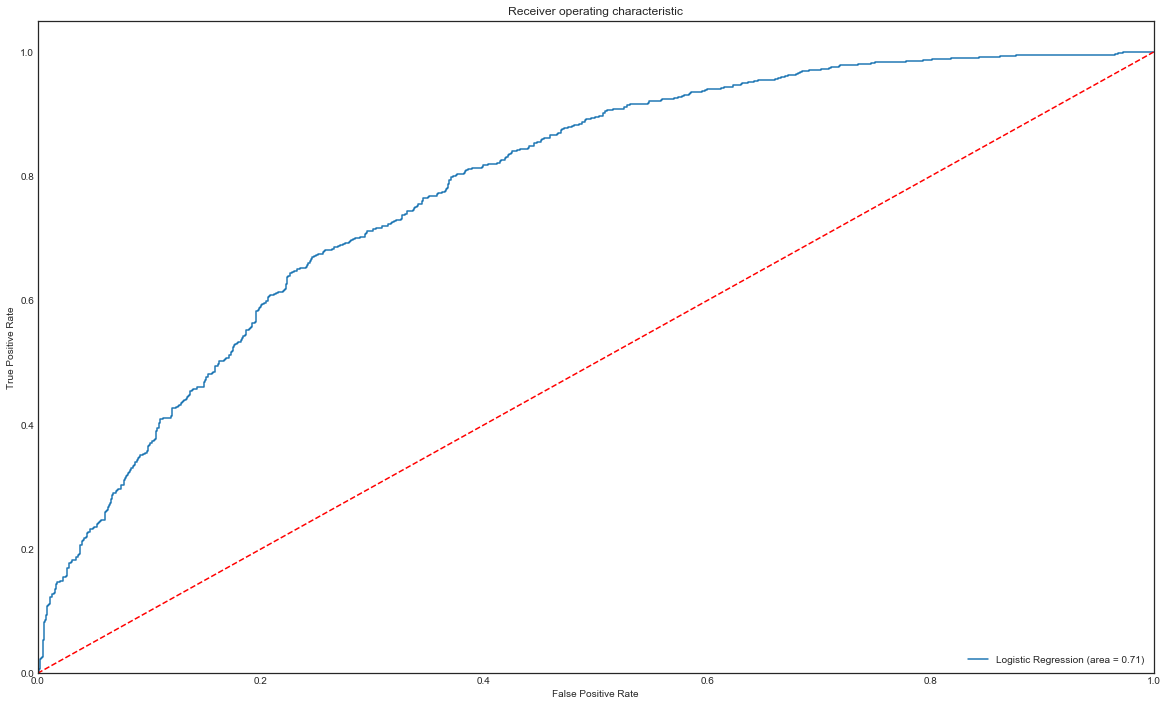

In [90]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy: 0.965205288796103


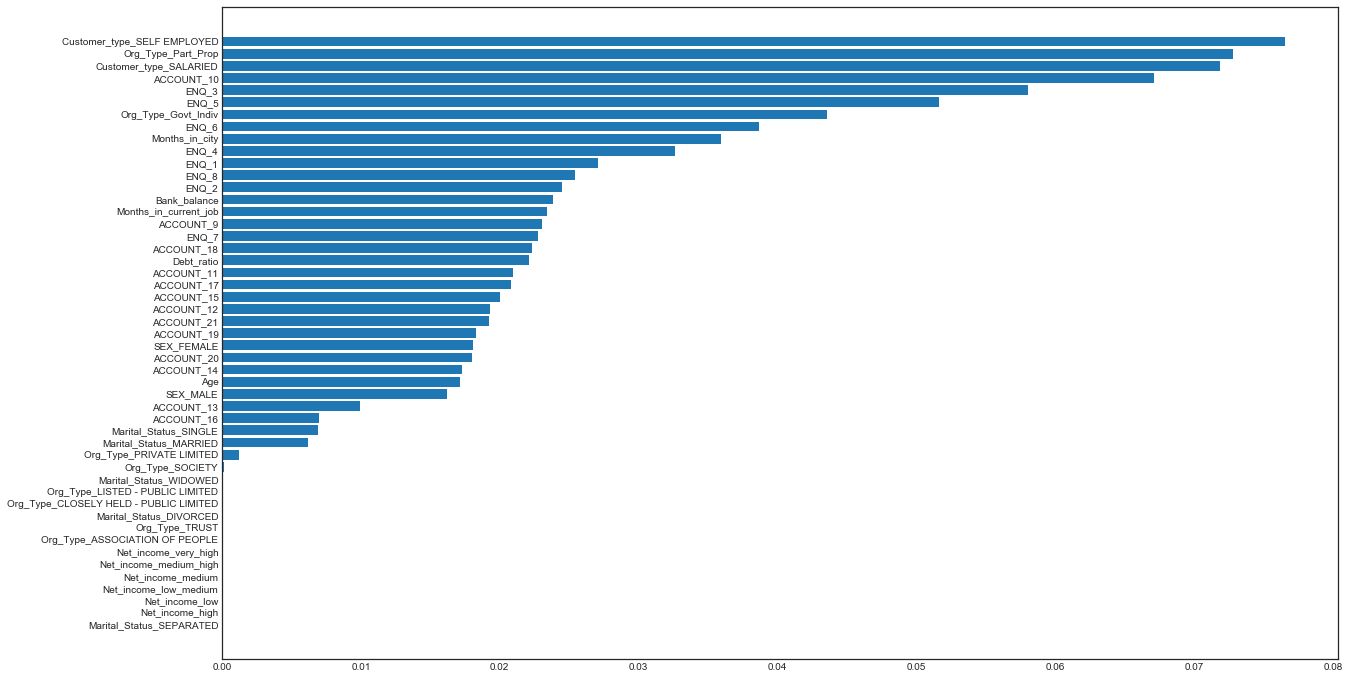

In [40]:
feature_imp = clf.feature_importances_
feature_imp_sorted = sorted(feature_imp,reverse = True)
cols = X_train.columns
cols_sorted = [x for _,x in sorted(zip(feature_imp,cols),reverse = True)]
plt.barh(cols_sorted, feature_imp_sorted)
plt.gca().invert_yaxis();

In [41]:
from sklearn.feature_selection import SelectFromModel
thresholds = np.sort(clf.feature_importances_)
for thresh in thresholds:
    selection = SelectFromModel(clf, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model=RandomForestClassifier(n_estimators=100)
    selection_model.fit(select_X_train,y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    print(thresh)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.0
Confusion Matrix:
 [[696   7]
 [ 45 689]]
Accuracy: 0.9638135003479471


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.0
Confusion Matrix:
 [[696   7]
 [ 45 689]]
Accuracy: 0.9638135003479471


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.0
Confusion Matrix:
 [[695   8]
 [ 43 691]]
Accuracy: 0.964509394572025


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.0
Confusion Matrix:
 [[699   4]
 [ 45 689]]
Accuracy: 0.9659011830201809


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.0
Confusion Matrix:
 [[697   6]
 [ 43 691]]
Accuracy: 0.9659011830201809


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.0
Confusion Matrix:
 [[697   6]
 [ 43 691]]
Accuracy: 0.9659011830201809


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.0
Confusion Matrix:
 [[699   4]
 [ 43 691]]
Accuracy: 0.9672929714683368


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.0
Confusion Matrix:
 [[698   5]
 [ 43 691]]
Accuracy: 0.9665970772442589


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.0
Confusion Matrix:
 [[692  11]
 [ 44 690]]
Accuracy: 0.9617258176757133


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


3.134089951927587e-06
Confusion Matrix:
 [[696   7]
 [ 48 686]]
Accuracy: 0.9617258176757133


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


4.642112517535186e-06
Confusion Matrix:
 [[699   4]
 [ 43 691]]
Accuracy: 0.9672929714683368


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


2.258341378310728e-05
Confusion Matrix:
 [[697   6]
 [ 41 693]]
Accuracy: 0.9672929714683368


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


3.832454529665324e-05
Confusion Matrix:
 [[697   6]
 [ 44 690]]
Accuracy: 0.965205288796103


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.00013956528450676095
Confusion Matrix:
 [[699   4]
 [ 45 689]]
Accuracy: 0.9659011830201809


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.0012238160213268203
Confusion Matrix:
 [[697   6]
 [ 45 689]]
Accuracy: 0.964509394572025


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.006171508570973486
Confusion Matrix:
 [[695   8]
 [ 43 691]]
Accuracy: 0.964509394572025


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.006933622892812279
Confusion Matrix:
 [[698   5]
 [ 43 691]]
Accuracy: 0.9665970772442589


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.006965146787752976
Confusion Matrix:
 [[695   8]
 [ 45 689]]
Accuracy: 0.9631176061238692


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.009933624724545967
Confusion Matrix:
 [[691  12]
 [ 43 691]]
Accuracy: 0.9617258176757133


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.016206747277919775
Confusion Matrix:
 [[694   9]
 [ 43 691]]
Accuracy: 0.9638135003479471


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.017153310987809724
Confusion Matrix:
 [[692  11]
 [ 43 691]]
Accuracy: 0.9624217118997912


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.01726798577860084
Confusion Matrix:
 [[696   7]
 [ 42 692]]
Accuracy: 0.9659011830201809


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.017979831923648857
Confusion Matrix:
 [[694   9]
 [ 42 692]]
Accuracy: 0.964509394572025


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.018052369135418352
Confusion Matrix:
 [[696   7]
 [ 43 691]]
Accuracy: 0.965205288796103


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.018324419660918
Confusion Matrix:
 [[694   9]
 [ 43 691]]
Accuracy: 0.9638135003479471


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.019228613819005817
Confusion Matrix:
 [[692  11]
 [ 44 690]]
Accuracy: 0.9617258176757133


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.019298777129557354
Confusion Matrix:
 [[692  11]
 [ 46 688]]
Accuracy: 0.9603340292275574


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.02005452036234009
Confusion Matrix:
 [[695   8]
 [ 45 689]]
Accuracy: 0.9631176061238692


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.020797211547839714
Confusion Matrix:
 [[694   9]
 [ 47 687]]
Accuracy: 0.9610299234516354


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.02097695259927931
Confusion Matrix:
 [[693  10]
 [ 49 685]]
Accuracy: 0.9589422407794015


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.022107679777218666
Confusion Matrix:
 [[694   9]
 [ 52 682]]
Accuracy: 0.9575504523312457


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.022292771321062988
Confusion Matrix:
 [[692  11]
 [ 49 685]]
Accuracy: 0.9582463465553236


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.022784649043602237
Confusion Matrix:
 [[689  14]
 [ 53 681]]
Accuracy: 0.953375086986778


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.02306880903745369
Confusion Matrix:
 [[690  13]
 [ 58 676]]
Accuracy: 0.9505915100904663


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.02341378087326188
Confusion Matrix:
 [[696   7]
 [ 53 681]]
Accuracy: 0.9582463465553236


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.02380825267628225
Confusion Matrix:
 [[694   9]
 [ 54 680]]
Accuracy: 0.9561586638830898


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.024501441855317014
Confusion Matrix:
 [[688  15]
 [ 57 677]]
Accuracy: 0.9498956158663883


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.025395094963859305
Confusion Matrix:
 [[686  17]
 [ 56 678]]
Accuracy: 0.9491997216423104


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.02706361169617663
Confusion Matrix:
 [[682  21]
 [ 54 680]]
Accuracy: 0.9478079331941545


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.03262287906842137
Confusion Matrix:
 [[682  21]
 [ 61 673]]
Accuracy: 0.942936673625609


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.035960558927602734
Confusion Matrix:
 [[683  20]
 [ 65 669]]
Accuracy: 0.940848990953375


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.038688498620768154
Confusion Matrix:
 [[681  22]
 [ 65 669]]
Accuracy: 0.9394572025052192


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.04358610683298012
Confusion Matrix:
 [[684  19]
 [ 73 661]]
Accuracy: 0.9359777313848295


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.051597132321688444
Confusion Matrix:
 [[684  19]
 [ 70 664]]
Accuracy: 0.9380654140570633


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.058067350262193965
Confusion Matrix:
 [[692  11]
 [ 95 639]]
Accuracy: 0.9262352122477383


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.0670737407035587
Confusion Matrix:
 [[703   0]
 [181 553]]
Accuracy: 0.8740431454418929


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.07185975936881783
Confusion Matrix:
 [[703   0]
 [304 430]]
Accuracy: 0.7884481558803061


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.07280906842741149
Confusion Matrix:
 [[703   0]
 [303 431]]
Accuracy: 0.7891440501043842


C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.07652210555651717
Confusion Matrix:
 [[332 371]
 [ 46 688]]
Accuracy: 0.7098121085594989


In [47]:
selection = SelectFromModel(clf, threshold=4.642112517535186e-06, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model=RandomForestClassifier(n_estimators=100)
selection_model.fit(select_X_train,y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

C:\Users\Ananya\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Confusion Matrix:
 [[696   7]
 [ 42 692]]
Accuracy: 0.9659011830201809


## XG Boost

In [25]:
xgb_clf = xgb.XGBClassifier(objective = 'binary:logistic', colsample_bytree = 0.4,
                learning_rate = 0.01, max_depth = 10, n_estimators = 30).fit(X_train, np.ravel(y_train))
preds = xgb_clf.predict(X_test)
preds = [round(value) for value in preds]
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
print("Accuracy:", accuracy_score(y_test, preds))

/Users/poojaaryamane/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix:
 [[693  10]
 [ 62 672]]
Accuracy: 0.9498956158663883


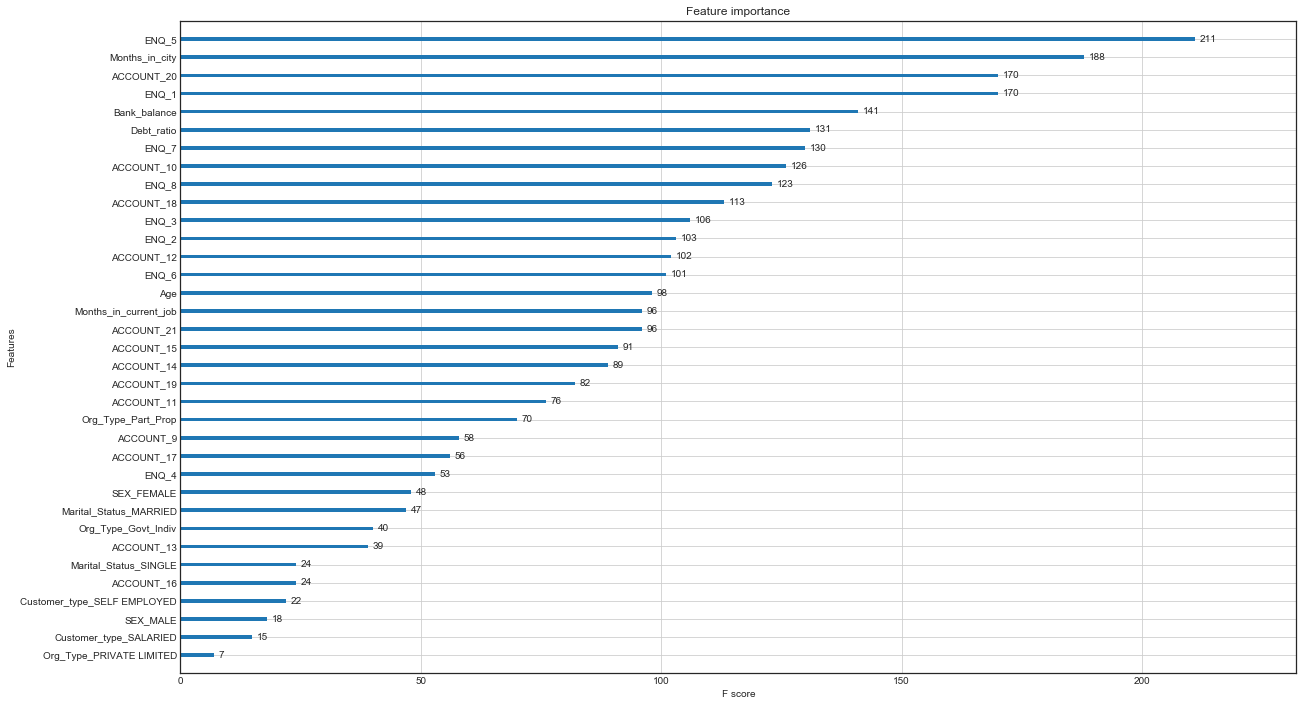

In [32]:
xgb.plot_importance(xgb_clf)
plt.rcParams["figure.figsize"] = (40, 30)
plt.show()
# variables with same value of feature imp are getting overlapped so not all 49 variables are visible

In [70]:
# select features using threshold
from sklearn.feature_selection import SelectFromModel
thresholds = np.sort(xgb_clf.feature_importances_)
for thresh in thresholds:
    selection = SelectFromModel(xgb_clf, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgb.XGBClassifier(objective = 'binary:logistic', colsample_bytree = 0.4,
                learning_rate = 0.01, max_depth = 10, n_estimators = 30)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    preds = [round(value) for value in y_pred]
    print(thresh)
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    print("Accuracy:", accuracy_score(y_test, preds))

C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0
Confusion Matrix:
 [[699   4]
 [ 59 675]]
Accuracy: 0.9561586638830898


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0
Confusion Matrix:
 [[699   4]
 [ 59 675]]
Accuracy: 0.9561586638830898


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0
Confusion Matrix:
 [[699   4]
 [ 59 675]]
Accuracy: 0.9561586638830898


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0
Confusion Matrix:
 [[699   4]
 [ 59 675]]
Accuracy: 0.9561586638830898


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0
Confusion Matrix:
 [[699   4]
 [ 59 675]]
Accuracy: 0.9561586638830898


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0
Confusion Matrix:
 [[699   4]
 [ 59 675]]
Accuracy: 0.9561586638830898


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0
Confusion Matrix:
 [[699   4]
 [ 59 675]]
Accuracy: 0.9561586638830898


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0
Confusion Matrix:
 [[699   4]
 [ 59 675]]
Accuracy: 0.9561586638830898


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0
Confusion Matrix:
 [[699   4]
 [ 59 675]]
Accuracy: 0.9561586638830898


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0
Confusion Matrix:
 [[699   4]
 [ 59 675]]
Accuracy: 0.9561586638830898


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0
Confusion Matrix:
 [[699   4]
 [ 59 675]]
Accuracy: 0.9561586638830898


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0
Confusion Matrix:
 [[699   4]
 [ 59 675]]
Accuracy: 0.9561586638830898


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0
Confusion Matrix:
 [[699   4]
 [ 59 675]]
Accuracy: 0.9561586638830898


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0
Confusion Matrix:
 [[699   4]
 [ 59 675]]
Accuracy: 0.9561586638830898


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0019201961
Confusion Matrix:
 [[689  14]
 [ 62 672]]
Accuracy: 0.9471120389700766


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.002185254
Confusion Matrix:
 [[694   9]
 [ 59 675]]
Accuracy: 0.9526791927627001


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0025123288
Confusion Matrix:
 [[698   5]
 [ 61 673]]
Accuracy: 0.954070981210856


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0026014785
Confusion Matrix:
 [[696   7]
 [ 62 672]]
Accuracy: 0.9519832985386222


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0026808097
Confusion Matrix:
 [[697   6]
 [ 62 672]]
Accuracy: 0.9526791927627001


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0032840453
Confusion Matrix:
 [[690  13]
 [ 61 673]]
Accuracy: 0.9485038274182325


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.003309771
Confusion Matrix:
 [[694   9]
 [ 58 676]]
Accuracy: 0.953375086986778


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0033691286
Confusion Matrix:
 [[685  18]
 [ 57 677]]
Accuracy: 0.9478079331941545


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0036998417
Confusion Matrix:
 [[693  10]
 [ 64 670]]
Accuracy: 0.9485038274182325


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.003910693
Confusion Matrix:
 [[692  11]
 [ 62 672]]
Accuracy: 0.9491997216423104


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.004032017
Confusion Matrix:
 [[694   9]
 [ 62 672]]
Accuracy: 0.9505915100904663


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.004301434
Confusion Matrix:
 [[693  10]
 [ 64 670]]
Accuracy: 0.9485038274182325


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0044801463
Confusion Matrix:
 [[691  12]
 [ 63 671]]
Accuracy: 0.9478079331941545


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0047032125
Confusion Matrix:
 [[694   9]
 [ 61 673]]
Accuracy: 0.9512874043145442


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.005168697
Confusion Matrix:
 [[698   5]
 [ 65 669]]
Accuracy: 0.9512874043145442


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0052054506
Confusion Matrix:
 [[690  13]
 [ 65 669]]
Accuracy: 0.9457202505219207


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.005574401
Confusion Matrix:
 [[694   9]
 [ 71 663]]
Accuracy: 0.9443284620737648


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0057908758
Confusion Matrix:
 [[691  12]
 [ 72 662]]
Accuracy: 0.941544885177453


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0064517832
Confusion Matrix:
 [[692  11]
 [ 66 668]]
Accuracy: 0.9464161447459986


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.0072541875
Confusion Matrix:
 [[692  11]
 [ 69 665]]
Accuracy: 0.9443284620737648


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.007283306
Confusion Matrix:
 [[695   8]
 [ 66 668]]
Accuracy: 0.9485038274182325


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.007810708
Confusion Matrix:
 [[695   8]
 [ 67 667]]
Accuracy: 0.9478079331941545


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.008035939
Confusion Matrix:
 [[694   9]
 [ 69 665]]
Accuracy: 0.9457202505219207


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.012003509
Confusion Matrix:
 [[700   3]
 [ 78 656]]
Accuracy: 0.9436325678496869


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.012274032
Confusion Matrix:
 [[688  15]
 [ 69 665]]
Accuracy: 0.941544885177453


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.02019715
Confusion Matrix:
 [[691  12]
 [ 76 658]]
Accuracy: 0.9387613082811412


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.020458398
Confusion Matrix:
 [[693  10]
 [ 80 654]]
Accuracy: 0.9373695198329853


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.022537718
Confusion Matrix:
 [[697   6]
 [ 90 644]]
Accuracy: 0.9331941544885177


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.03482655
Confusion Matrix:
 [[698   5]
 [ 97 637]]
Accuracy: 0.9290187891440501


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.03813394
Confusion Matrix:
 [[694   9]
 [108 626]]
Accuracy: 0.918580375782881


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.047897805
Confusion Matrix:
 [[697   6]
 [188 546]]
Accuracy: 0.8649965205288797


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.052147035
Confusion Matrix:
 [[703   0]
 [303 431]]
Accuracy: 0.7891440501043842


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.06063199
Confusion Matrix:
 [[703   0]
 [303 431]]
Accuracy: 0.7891440501043842


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.27561766
Confusion Matrix:
 [[332 371]
 [ 46 688]]
Accuracy: 0.7098121085594989


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.2977086
Confusion Matrix:
 [[332 371]
 [ 46 688]]
Accuracy: 0.7098121085594989


In [73]:
# Final Model
selection = SelectFromModel(xgb_clf, threshold=0.003309771, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = xgb.XGBClassifier(objective = 'binary:logistic', colsample_bytree = 0.4,
                learning_rate = 0.01, max_depth = 10, n_estimators = 30)
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)
preds = [round(value) for value in y_pred]
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
print("Accuracy:", accuracy_score(y_test, preds))

C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Confusion Matrix:
 [[694   9]
 [ 58 676]]
Accuracy: 0.953375086986778


## Light GBM

In [74]:
lgbm_clf = lgb.LGBMClassifier(num_leaves = 45, learning_rate = 0.65, n_estimators = 40).fit(X_train, np.ravel(y_train))
preds = lgbm_clf.predict(X_test)
preds = [round(value) for value in preds]
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
print("Accuracy:", accuracy_score(y_test, preds))

Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


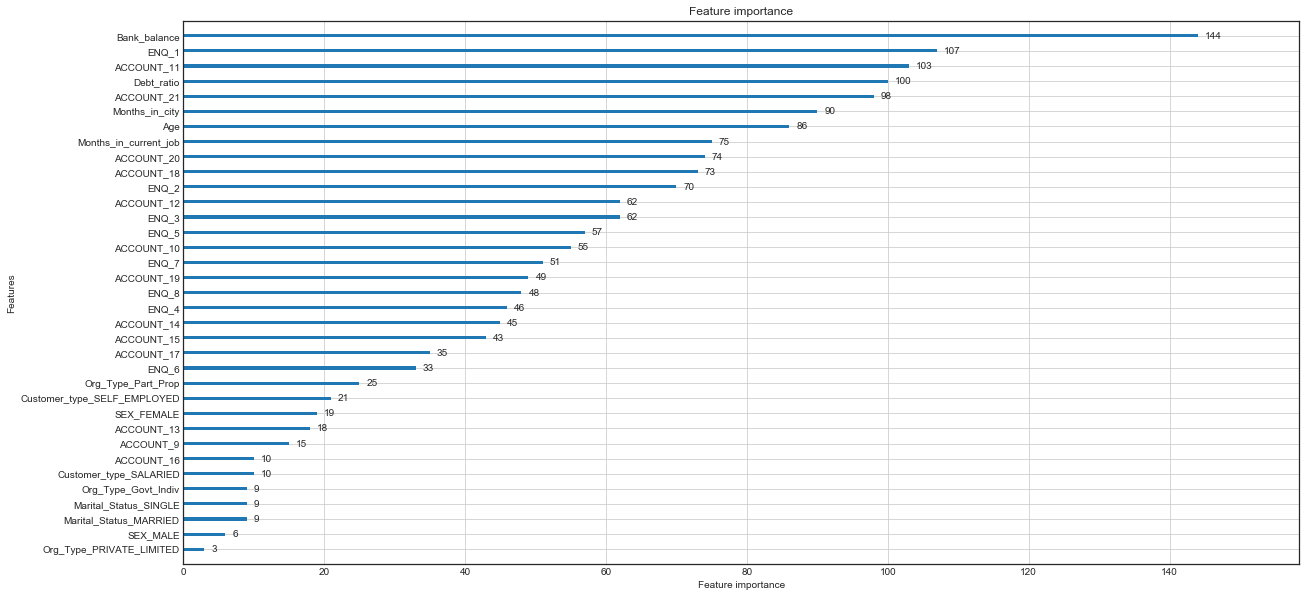

In [76]:
lgb.plot_importance(lgbm_clf)
plt.rcParams["figure.figsize"] = (40, 30)
plt.show()
# variables with same value of feature imp are getting overlapped so not all 49 variables are visible

In [77]:
# select features using threshold
from sklearn.feature_selection import SelectFromModel
thresholds = np.sort(lgbm_clf.feature_importances_)
for thresh in thresholds:
    selection = SelectFromModel(lgbm_clf, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = lgb.LGBMClassifier(num_leaves = 45, learning_rate = 0.65, n_estimators = 40)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    preds = [round(value) for value in y_pred]
    print(thresh)
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    print("Accuracy:", accuracy_score(y_test, preds))

C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0
Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0
Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0
Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0
Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0
Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0
Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0
Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0
Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0
Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0
Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0
Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0
Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0
Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0
Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


3
Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


6
Confusion Matrix:
 [[694   9]
 [ 49 685]]
Accuracy: 0.9596381350034795


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


9
Confusion Matrix:
 [[695   8]
 [ 47 687]]
Accuracy: 0.9617258176757133


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


9
Confusion Matrix:
 [[695   8]
 [ 47 687]]
Accuracy: 0.9617258176757133


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


9
Confusion Matrix:
 [[695   8]
 [ 47 687]]
Accuracy: 0.9617258176757133


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


10
Confusion Matrix:
 [[699   4]
 [ 48 686]]
Accuracy: 0.9638135003479471


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


10
Confusion Matrix:
 [[699   4]
 [ 48 686]]
Accuracy: 0.9638135003479471


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


15
Confusion Matrix:
 [[692  11]
 [ 50 684]]
Accuracy: 0.9575504523312457


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


18
Confusion Matrix:
 [[691  12]
 [ 50 684]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


19
Confusion Matrix:
 [[695   8]
 [ 49 685]]
Accuracy: 0.9603340292275574


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


21
Confusion Matrix:
 [[695   8]
 [ 46 688]]
Accuracy: 0.9624217118997912


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


25
Confusion Matrix:
 [[697   6]
 [ 51 683]]
Accuracy: 0.9603340292275574


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


33
Confusion Matrix:
 [[692  11]
 [ 46 688]]
Accuracy: 0.9603340292275574


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


35
Confusion Matrix:
 [[690  13]
 [ 46 688]]
Accuracy: 0.9589422407794015


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


43
Confusion Matrix:
 [[694   9]
 [ 47 687]]
Accuracy: 0.9610299234516354


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


45
Confusion Matrix:
 [[689  14]
 [ 51 683]]
Accuracy: 0.9547668754349339


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


46
Confusion Matrix:
 [[693  10]
 [ 49 685]]
Accuracy: 0.9589422407794015


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


48
Confusion Matrix:
 [[687  16]
 [ 47 687]]
Accuracy: 0.9561586638830898


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


49
Confusion Matrix:
 [[689  14]
 [ 48 686]]
Accuracy: 0.9568545581071677


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


51
Confusion Matrix:
 [[692  11]
 [ 47 687]]
Accuracy: 0.9596381350034795


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


55
Confusion Matrix:
 [[687  16]
 [ 49 685]]
Accuracy: 0.9547668754349339


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


57
Confusion Matrix:
 [[683  20]
 [ 48 686]]
Accuracy: 0.9526791927627001


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


62
Confusion Matrix:
 [[682  21]
 [ 45 689]]
Accuracy: 0.954070981210856


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


62
Confusion Matrix:
 [[682  21]
 [ 45 689]]
Accuracy: 0.954070981210856


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


70
Confusion Matrix:
 [[661  42]
 [ 31 703]]
Accuracy: 0.9491997216423104


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


73
Confusion Matrix:
 [[673  30]
 [ 38 696]]
Accuracy: 0.9526791927627001


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


74
Confusion Matrix:
 [[664  39]
 [ 45 689]]
Accuracy: 0.941544885177453


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


75
Confusion Matrix:
 [[681  22]
 [ 44 690]]
Accuracy: 0.954070981210856


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


86
Confusion Matrix:
 [[667  36]
 [ 54 680]]
Accuracy: 0.9373695198329853


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


90
Confusion Matrix:
 [[651  52]
 [ 61 673]]
Accuracy: 0.9213639526791928


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


98
Confusion Matrix:
 [[629  74]
 [ 92 642]]
Accuracy: 0.8844815588030619
100


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Confusion Matrix:
 [[620  83]
 [114 620]]
Accuracy: 0.8629088378566457


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


103
Confusion Matrix:
 [[536 167]
 [137 597]]
Accuracy: 0.7884481558803061
107
Confusion Matrix:
 [[530 173]
 [206 528]]
Accuracy: 0.7362560890744607


C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


144
Confusion Matrix:
 [[399 304]
 [361 373]]
Accuracy: 0.5372303409881698


In [78]:
# Final model
selection = SelectFromModel(lgbm_clf, threshold=10, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = lgb.LGBMClassifier(num_leaves = 45, learning_rate = 0.65, n_estimators = 40)
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)
preds = [round(value) for value in y_pred]
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
print("Accuracy:", accuracy_score(y_test, preds))

C:\Users\Ananya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Confusion Matrix:
 [[699   4]
 [ 48 686]]
Accuracy: 0.9638135003479471
